<font style="font-size:28px;" align="left"><b> GKP states </b></font>
<br>
_prepared by Schrödinger Cats_

So far, we have discussed how we can manipulate quantum states of light, which might seems pretty strange compared to the qubit based quantum circuits that you have learned before. Some of the algorithms that can be executed on a photonic quantum computer will take different form compared to qubit based algorithms, which makes a photonic quantum computer unique. In other words, it has its own strengths and weaknesses. However, you might wonder whether it is possible to do the usual qubit-based quantum computing using photonic platform. This is the question that we will try to investigate today. Remember that this is still an open research area, so there are still rooms for new innovations and ideas.

We have talked about qumodes and how it is different from a qubit. Your intuition might say that we should be able to encode qubits into qumodes, because there must be a lot of ways to encode a two-dimensional space into an infinite-dimensional one. If this is possible, one can run any qubit-based quantum algorithm using qumodes. Indeed, there are many ways to do it. The problem is that most of these schemes are extremely sensitive to noise on the qumodes. A way that has been proven to be robust against errors is to treat states of light which are called GKP states (GKP stands for Gottesman-Kitaev-Preskill) as qubits.
GKP states are linear combinations of the following two basis states:
$$
\begin{gathered}
|0\rangle_{GKP}=\sum_{n}|(2 n) \sqrt{\pi \hbar}\rangle_{x} \\
|1\rangle_{GKP}=\sum_{n}|(2 n+1) \sqrt{\pi \hbar}\rangle_{x}
\end{gathered}
$$
where the subscript $x$ means that the quantum states in the sum are eigenstates of the quadrature observable $\hat{X}$. Therefore, an arbitrary qubit $|\psi\rangle=\alpha|0\rangle+\beta|1\rangle$ can be expressed through the qumode as
$$
|\psi\rangle_{G K P}=\alpha|0\rangle_{G K P}+\beta|1\rangle_{G K P}
$$
The only problem is that producing these GKP states is physically impossible as they would require infinite energy. Instead, we can produce approximate versions of them and still perform quantum computations with good accuracy.

In general, if we perform an operation (apply a gate) to a GKP state, the output won't necessarily be a GKP state. Our qumodes can remain within the subspace spanned by the GKP basis by putting a restriction on the set of gates we can apply to them. For example, we see that applying a displacement gate by $\sqrt{\pi \hbar}$ to $|0\rangle_{G K P}$ gives the $|1\rangle_{G K P}$ state, and vice versa. Does this sound similar to anything you have encountered? Yes, this is just like the qubit bit-flip or Pauli X. Similarly, you can show that Hadamard gate corresponds to a rotation by $\pi / 2$.

In [1]:
# Import relevant libraries
import strawberryfields as sf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors, colorbar

# Set the scale for phase space
sf.hbar = 1
scale = np.sqrt(sf.hbar * np.pi)

GKPs have Wigner functions with peaks arranged on a square lattice. We will try to demonstrate that here. Sometimes, the X quadrature and P quadrature is called q and p quadrature respectively. This will be the naming convention in this notebook. We will also switch to the "bosonic" backend which borrows some of the best features of "gaussian" and "fock" backends. Specifically, the bosonic backend is tailored to simulate states which can be represented as a linear combination of Gaussian functions in phase space. It provides very succinct descriptions of Gaussian states, just like the gaussian backend, but it can also provide descriptions of non-Gaussian states as well. 

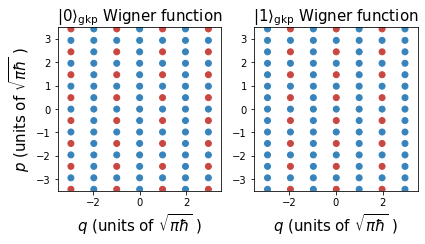

In [2]:
# Create a GKP |0> state
prog = sf.Program(1)

with prog.context as q:
    sf.ops.GKP() | q

eng = sf.Engine("bosonic")
gkp_0 = eng.run(prog).state

# Create a GKP |1> state
prog = sf.Program(1)

with prog.context as q:
    sf.ops.GKP() | q
    sf.ops.Xgate(np.sqrt(np.pi * sf.hbar)) | q

eng = sf.Engine("bosonic")
gkp_1 = eng.run(prog).state

# Get the phase space coordinates of the delta functions for the two states
q_coords_0 = gkp_0.means().real[:, 0]
p_coords_0 = gkp_0.means().real[:, 1]
q_coords_1 = gkp_1.means().real[:, 0]
p_coords_1 = gkp_1.means().real[:, 1]

# Determine whether the delta functions are positively or negatively weighted
delta_sign_0 = np.sign(gkp_0.weights().real)
delta_sign_1 = np.sign(gkp_1.weights().real)

# Plot the locations and signs of the deltas
fig,ax = plt.subplots(1, 2)
ax[0].scatter(q_coords_0 / scale,
           p_coords_0 / scale,
           c=delta_sign_0,
           cmap=plt.cm.RdBu, vmin=-1.5, vmax=1.5)
ax[1].scatter(q_coords_1 / scale,
           p_coords_1 / scale,
           c=delta_sign_0,
           cmap=plt.cm.RdBu, vmin=-1.5, vmax=1.5)
for i in range(2):
    ax[i].set_xlim(-3.5, 3.5)
    ax[i].set_ylim(-3.5, 3.5)
    ax[i].set_xlabel(r'$q$ (units of $\sqrt{\pi\hbar}$ )', fontsize=15)
    ax[i].set_aspect("equal")
ax[0].set_title(r'$|0\rangle_{\rm gkp}$ Wigner function', fontsize=15)
ax[1].set_title(r'$|1\rangle_{\rm gkp}$ Wigner function', fontsize=15)
ax[0].set_ylabel(r'$p$ (units of $\sqrt{\pi\hbar}$ )', fontsize=15)
fig.tight_layout()
plt.show()

<br>
<font style="font-size:20px;" align="left"><b> Physical approximate GKP states

Phyiscal, finite-energy GKP states can be constructed by applying a "Fock damping operator" to the ideal states, which essentially damps out the contribution of high photon number states in the ideal GKP state:

$\left|k^{\epsilon}\right\rangle_{\mathrm{gkp}}=e^{-\epsilon \hat{n}}|k\rangle_{\mathrm{gkp}}, k=0,1$

where $\hat{n}$ is the photon number operator. We will work with physical approximate GKP states as this is practically realizable. We now investigate the effect of the $\epsilon$, which is called the finite energy parameter, to the Wigner function.

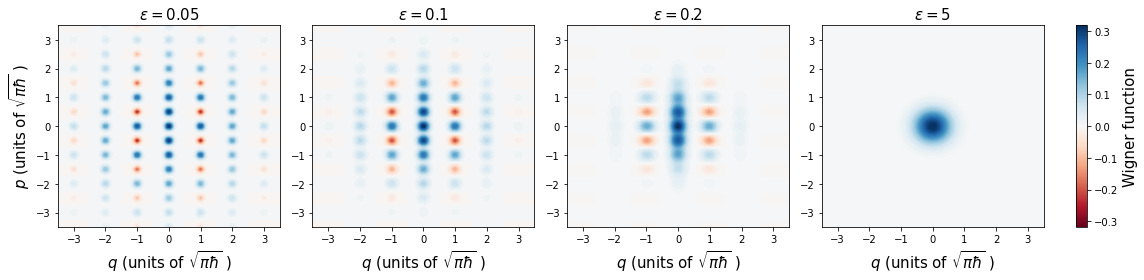

In [3]:
# Choose some values of epsilon
epsilons = [0.05, 0.1, 0.2, 5]

# Pick a region of phase space to plot
quad = np.linspace(-3.5, 3.5, 200) * scale

wigners = []

for epsilon in epsilons:

    # Create a GKP |0> state
    prog = sf.Program(1)

    with prog.context as q:
        sf.ops.GKP(epsilon=epsilon) | q

    eng = sf.Engine("bosonic")
    gkp = eng.run(prog).state

    # Calculate the Wigner function
    wigner = gkp.wigner(mode=0, xvec=quad, pvec=quad)
    wigners.append(wigner)

# Plot the results
fig, axs = plt.subplots(1, 5, figsize=(16, 4), gridspec_kw={"width_ratios": [1, 1, 1, 1, 0.05]})
cmap = plt.cm.RdBu
cmax = np.real_if_close(np.amax(np.array(wigners)))
norm = colors.Normalize(vmin=-cmax, vmax=cmax)
cb1 = colorbar.ColorbarBase(axs[4], cmap=cmap, norm=norm, orientation="vertical")
for i in range(4):
    axs[i].contourf(
        quad / scale,
        quad / scale,
        wigners[i],
        levels=60,
        cmap=plt.cm.RdBu,
        vmin=-cmax,
        vmax=cmax,
    )
    axs[i].set_title(r'$\epsilon =$'+str(epsilons[i]), fontsize=15)
    axs[i].set_xlabel(r'$q$ (units of $\sqrt{\pi\hbar}$ )', fontsize=15)
axs[0].set_ylabel(r'$p$ (units of $\sqrt{\pi\hbar}$ )', fontsize=15)
cb1.set_label("Wigner function", fontsize=15)
fig.tight_layout()
plt.show()

As you can see, as we increase the $\epsilon$, this means that the higher photon number states are more damped and hence the energy is more limited. From the Wigner function, one can see that the higher the $\epsilon$:
1. the faster the Wigner function fades from the centre, this means the contribution from high photon number contribution is getting weaker and weaker
2. the dots are getting closer and closer, which means that the higher photon number states in the superposition are not exactly at the same place (not at integer coordinates in the diagram)
3. each dot becomes more spread out, which means that instead of having sharp superposition of position quadrature eigentstates at discrete positions, we have more spread out superposition

## Initializing a GKP state

We can specify the state of the GKP state by providing two parameters, $\theta$ and $\phi$ as specified in the following equation

$$
|\psi\rangle_{g k p}=\cos \frac{\theta}{2}|0\rangle_{g k p}+e^{-i \phi} \sin \frac{\theta}{2}|1\rangle_{g k p}
$$

we pass the parameters in the argument *state* as follows

sf.ops.GKP(state=$[\theta,\phi]$, epsilon=$\epsilon$)

<br>
<font style="font-size:20px;" align="left"><b> GKP "Pauli" measurements using Homodyne

Pauli measurements in the usual two-level qubit based system corresponds to Homodyne measurement in GKP qubit. Let's try to get a plus state and perform a Homodyne measurement on it to experience it hands on. Remember that the plus state can be written as follows:

$$|+\rangle = \frac{1}{\sqrt{2}}\left( |0\rangle + |1\rangle \right)$$

which means in the GKP parameters, $\theta = \pi/2$ and $\phi = 0$.

In the example below, we will use a function calc_and_plot_marginals, which will compute the distributions of p, q-p, and q quadrature, each corresponding to Pauli X, Y, and Z respectively. You do not need to understand what the function is doing to be able to follow the notebook, however, it is always good to try to take a look and understand what it is doing. In the distribution plot generated, you will see blue colored and red colored bins. Blue bins represent the +1 result and red bins represent the -1 result of the Pauli measurements.

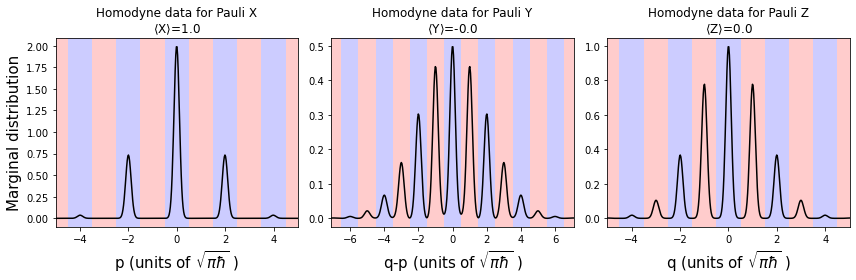

In [4]:
# Create a GKP |+> state
plus = [np.pi / 2, 0]
prog = sf.Program(1)

with prog.context as q:
    sf.ops.GKP(state=plus, epsilon=0.08) | q

eng = sf.Engine("bosonic")
gkp = eng.run(prog).state

def calc_and_plot_marginals(state, mode):
    '''Calculates and plots the p, q-p, and q quadrature marginal
    distributions for a given circuit mode. These can be used to determine
    the Pauli X, Y, and Z outcomes for a GKP qubit.

    Args:
        state (object): a strawberryfields ``BaseBosonicState`` object
        mode (int): index for the circuit mode
    '''
    # Calculate the marginal distributions.
    # The rotation angle in phase space is specified by phi
    marginals = []
    phis = [np.pi / 2, -np.pi / 4, 0]
    quad = np.linspace(-5, 5, 400) * scale
    for phi in phis:
        marginals.append(state.marginal(mode, quad, phi=phi))

    # Plot the results
    paulis = ["X", "Y", "Z"]
    homodynes = ["p", "q-p", "q"]
    expectations = np.zeros(3)

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    for i in range(3):
        if i == 1:
            # Rescale the outcomes for Pauli Y
            y_scale = np.sqrt(2 * sf.hbar) / scale
            axs[i].plot(quad * y_scale, marginals[i] / y_scale, 'k-')
            axs[i].set_xlim(quad[0] * y_scale, quad[-1] * y_scale)

            # Calculate Pauli expectation value
            # Blue bins are weighted +1, red bins are weighted -1
            bin_weights = 2 * (((quad * y_scale - 0.5) // 1) % 2) - 1
            integrand = (marginals[i] / y_scale) * bin_weights
            expectations[i] = np.trapz(integrand, quad * y_scale)
        else:
            axs[i].plot(quad / scale, marginals[i] * scale, 'k-')
            axs[i].set_xlim(quad[0] / scale, quad[-1] / scale)

            # Calculate Pauli expectation value
            # Blue bins are weighted +1, red bins are weighted -1
            bin_weights = 2 * (((quad / scale - 0.5) // 1) % 2) - 1
            integrand = (marginals[i] * scale) * bin_weights
            expectations[i] = np.trapz(integrand, quad / scale)

        # Color the qubit bins blue and red
        for j in range(-10, 10):
            axs[i].axvspan((2 * j - 0.5), (2 * j + 0.5), alpha=0.2, facecolor='b')
            axs[i].axvspan((2 * j + 0.5), (2 * j + 1.5), alpha=0.2, facecolor='r')

        axs[i].set_title("Homodyne data for Pauli " + paulis[i] +
                         "\n" + r'$\langle$'+paulis[i]+r'$\rangle$='+
                         str(np.around(expectations[i],2)))
        axs[i].set_xlabel(homodynes[i] + r' (units of $\sqrt{\pi\hbar}$ )', fontsize=15)
    axs[0].set_ylabel("Marginal distribution", fontsize=15)
    fig.tight_layout()
    plt.show()

calc_and_plot_marginals(gkp, 0)

Here, you can see that almost all Pauli X measurement gives +1 result as the probability distribution is heavily concentrated in the blue bins. This is expected from a plus state, as you remember from QBronze.

<br>
<font style="font-size:20px;" align="left"><b> GKP One-qumode Clifford Gates

To have a universal quantum computation, one must use a set of universal gates. In qubit based QC, one of such sets consists of a set of Clifford gates and a T-gate. Let's show the one qumode Clifford gates first.

<br>
<font style="font-size:18px;" align="left"><b> X gate equivalent

First, we create a $|0\rangle_{GKP}$ state and see that the quadrature distributions.

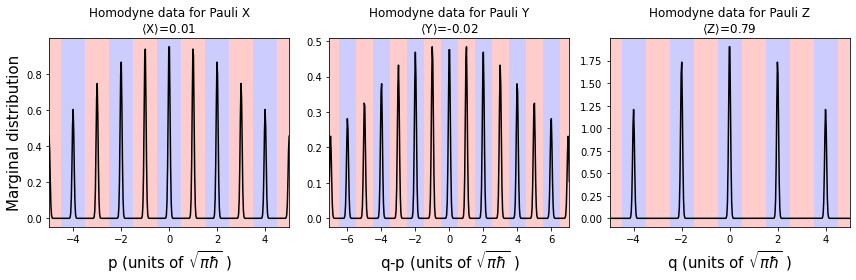

In [5]:
# Create a GKP state
prog = sf.Program(1)

with prog.context as q:
    sf.ops.GKP(epsilon=0.01) | q

eng = sf.Engine("bosonic")
gkp = eng.run(prog).state

#Calculate and plot marginals
calc_and_plot_marginals(gkp, 0)

Now, we can apply the Pauli X or bit flip operation, we shall expect the Z measurement to flip as now the state becomes $|1\rangle_{GKP}$

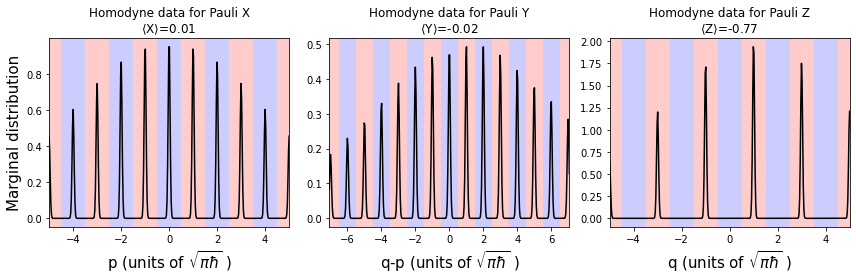

In [6]:
# Create a GKP state
prog = sf.Program(1)

with prog.context as q:
    sf.ops.GKP(epsilon=0.01) | q
    #apply bit flip
    sf.ops.Xgate(np.sqrt(np.pi * sf.hbar)) | q

eng = sf.Engine("bosonic")
gkp = eng.run(prog).state

#Calculate and plot marginals
calc_and_plot_marginals(gkp, 0)

<br>
<font style="font-size:18px;" align="left"><b> Hadamard gate equivalent

Hadamard gate can be implemented by 90 degrees rotation gate, and it transforms the computational basis to Hadamard basis (the plus-minus states).

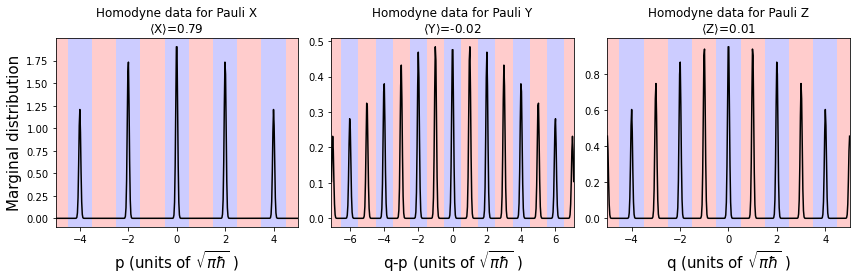

In [7]:
# Create a GKP state
prog = sf.Program(1)

with prog.context as q:
    sf.ops.GKP(epsilon=0.01) | q
    sf.ops.Rgate(np.pi/2) | q

eng = sf.Engine("bosonic")
gkp = eng.run(prog).state

#Calculate and plot marginals
calc_and_plot_marginals(gkp, 0)

As you can see, it switches the X and Z measurement results as expected.

<br>
<font style="font-size:20px;" align="left"><b> GKP Two-qumode Clifford Gate

Other than one qumode gates, one can also do two-qumode gate which mimics the two qubit gates like CNOT and CZ.

<br>
<font style="font-size:18px;" align="left"><b> CNOT equivalent

Now, we try to demonstrate a CNOT gate with $|1\rangle_{GKP}$ as the control qubit and $|0\rangle_{GKP}$ as the target. We should expect the target state to be flipped as the control qubit is 1.

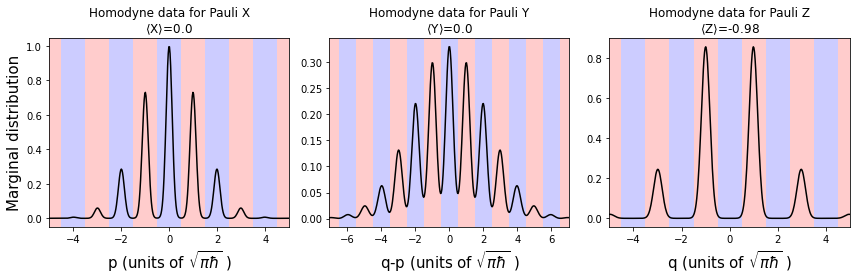

In [8]:
prog = sf.Program(2)

with prog.context as q:
    sf.ops.GKP(state=[np.pi,0],epsilon=0.1) | q[0] #this is GKP |1>
    sf.ops.GKP(state=[0,0],epsilon=0.1) | q[1] #this is GKP |0>
    sf.ops.CXgate(1) | (q[0],q[1]) #the first register is the control qubit

eng = sf.Engine("bosonic")
gkp = eng.run(prog).state

calc_and_plot_marginals(gkp, 1)

## Exercise 1

Can you create an EPR pair (or Bell state) using physical GKP qubits?

In [ ]:
#YOUR SOLUTION HERE

<br>
<font style="font-size:20px;" align="left"><b> GKP T-Gate

As we have learned, Clifford gates alone cannot comprise a universal quantum computing. We need something non-Clifford, such as T-gate.

The $T$ gate is a single-qubit operation given by:
$$
T=\left(\begin{array}{cc}
1 & 0 \\
0 & \exp \left(\frac{i \pi}{4}\right)
\end{array}\right)
$$
The T gate is related to the $\mathrm{S}$ gate by the relationship $S=T^{2}$.

T-gate in CV quantum computing can be done through gate teleportation by using an ancillary GKP qubit "magic state" and Gaussian operations. This means performing the following steps:
The steps to apply the T gate build on all the previous examples we’ve seen:

1. Put the data state as control to a CX gate, i.e. the equivalent of CNOT gate, with a particular state called "magic state" as the other qumode input (called ancillary mode).

2. Perform an X quadrature (equivalent of Pauli Z) measurement on the ancillary mode via a binned X quadrature homodyne measurement.

3. Based on the outcome of the homodyne, apply a quadratic phase gate to the data state.

The magic state mentioned above is $|M\rangle_{\mathrm{gkp}}=\frac{1}{\sqrt{2}}\left(e^{-i \pi / 8}|0\rangle_{\mathrm{gkp}}+e^{i \pi / 8}|1\rangle_{\mathrm{gkp}}\right)$.

We will now construct the T-gate cirucit. Here, we apply a T-gate to the magic state itself. Can you figure out before running the code what state will the output be in?

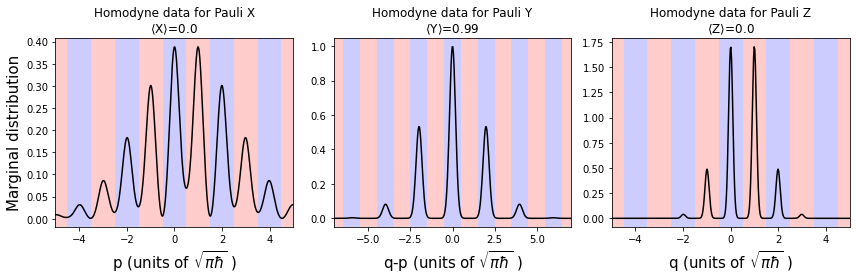

In [9]:
# Define a binning function to get the Pauli Z outcome for the feedforward
def gkp_binning(x):
    '''Bins a homodyne outcome to a binary 0 or 1 according to the GKP bin structure.
    Pauli +1 (-1) corresponds to 0 (1).

    Args:
        x (float): homodyne outcome value
    '''
    term_1 = (x + np.sqrt(np.pi) / 2) / np.sqrt(4 * np.pi)
    term_2 = (x + np.sqrt(np.pi) / 2) // np.sqrt(4 * np.pi)
    return (term_1 - term_2) // 0.5

# Create GKP magic states and perform the T gate teleportation circuit
magic = [np.pi / 2, - np.pi / 4]
prog = sf.Program(2)

with prog.context as q:
    sf.ops.GKP(state=magic, epsilon = 0.1) | q[0]
    sf.ops.GKP(state=magic, epsilon = 0.1) | q[1]
    sf.ops.CXgate(1) | (q[0], q[1])
    sf.ops.MeasureHomodyne(0, select=np.sqrt(np.pi * sf.hbar)) | q[1]
    sf.ops.Pgate(gkp_binning(q[1].par)) | q[0]

eng = sf.Engine("bosonic")
gkp = eng.run(prog).state

calc_and_plot_marginals(gkp, 0)

As you can see, it is in the Pauli Y eigenstate $|+i\rangle$.

## Exercise 2

Can you perform a T gate on $|0\rangle_{GKP}$? Try to make a prediction beforehand and compare the result with your prediction. Subsequently, simulate a measurement of Homodyne detector on X quadrature 5000 times, assign a value of +1 and -1 depending on the result (this corresponds to Pauli Z measurement).

In [ ]:
#YOUR SOLUTION HERE